In [1]:
from PIL import Image
import numpy as np
import scipy.optimize
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
from time import perf_counter


Load image

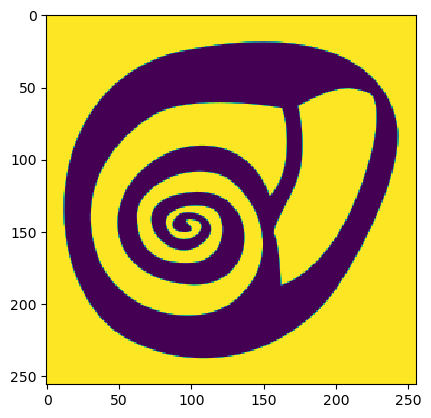

In [2]:
img = np.array(Image.open("test_img/image01.png")) / 255.0
img = img[:, :, 2]
img = (img - np.amin(img)) / (np.amax(img)-np.amin(img))

plt.figure()
plt.imshow(img)
plt.show()

Extract contour

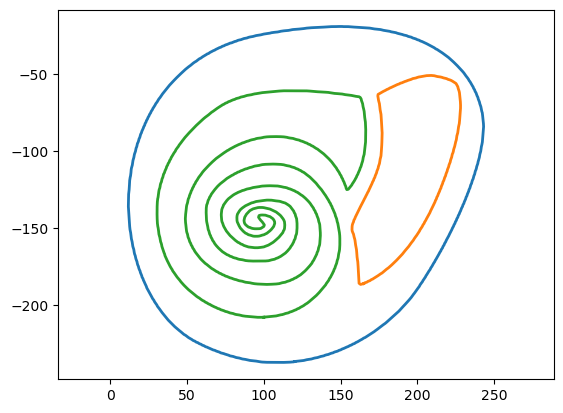

In [3]:
from skimage import measure

contours = []

plt.figure()
for contour in measure.find_contours(img, 0.5):
    contour = np.flip(contour)
    contour[:, 1] *= -1
    contours.append(contour)
    plt.plot(contour[:, 0], contour[:, 1], linewidth=2)
plt.axis('equal')
plt.show()

Segment fitting test

0.025652507053850915
0.010045592083649968
0.007165173061862928
0.0024288486495390726
0.002116149576297799
0.0010932965961527596
0.000928521480220601


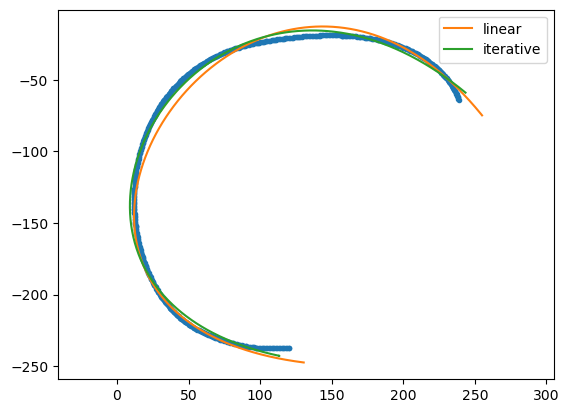

In [4]:
seg = contours[0][0:2*len(contours[0])//3, :]
plt.figure()
plt.plot(seg[:, 0], seg[:, 1], '.')


def closest_point(c, p):
    """closest point on curve"""
    # e^T c c^T e' - p c^T e' = 0
    ccT = c @ c.T
    pcT = p @ c.T
    a0 = ccT[0][1] - pcT[1]
    a1 = 2*ccT[0][2] + ccT[1][1] - 2*pcT[2]
    a2 = 3*ccT[0][3] + 2*ccT[1][2] + ccT[2][1] - 3*pcT[3]
    a3 = 3*ccT[1][3] + 2*ccT[2][2] + ccT[3][1]
    a4 = 3*ccT[2][3] + 2*ccT[3][2]
    a5 = 3*ccT[3][3]
    roots = np.roots([a5, a4, a3, a2, a1, a0])
    et0 = [1, 0, 0, 0]
    et1 = [1, 1, 1, 1]
    errs = [
        (0.0, np.linalg.norm(et0 @ c - p)),
        (1.0, np.linalg.norm(et1 @ c - p))
    ]
    for t in roots:
        if abs(t.imag) > 1e-6:
            continue
        t = t.real
        if not 0 < t < 1:
            continue
        et = [t**0, t**1, t**2, t**3]
        err = np.linalg.norm(et @ c - p)
        errs.append((t, err))
    return errs[np.argmin(np.array(errs)[:, 1])]


# linear least squares
ts = np.linspace(0, 1, len(seg))
eT = np.array([ts**0, ts**1, ts**2, ts**3])
c1 = np.linalg.solve(eT@eT.T, eT@seg)
p1 = eT.T @ c1
plt.plot(p1[:, 0], p1[:, 1], '-', label='linear')

# test closest point function
if False:
    plt.plot([0], [0], 'o')
    t, d = closest_point(c1, [0, 0])
    p = [t**0, t**1, t**2, t**3] @ c1
    plt.plot([p[0]], [p[1]], 'o')

# iterative linear fit
c2 = np.array(c1)
p2 = np.array(p1)
dts = 0.0 * ts
for iter in range(10):
    for i in range(len(ts)):
        t, d = closest_point(c2, seg[i])
        dts[i] = t - ts[i]
        ts[i] += 1.5*dts[i]
    ts = (ts-ts[0]) / (ts[-1]-ts[0])
    eT = np.array([ts**0, ts**1, ts**2, ts**3])
    c2 = np.linalg.solve(eT@eT.T, eT@seg)
    p2 = eT.T @ c2
    maxdt = np.amax(abs(dts))
    print(maxdt)
    if maxdt < 1e-3:
        break
plt.plot(p2[:, 0], p2[:, 1], '-', label='iterative')


plt.legend()
plt.axis('equal')
plt.show()

Spline fitting test

1.5729185909731314 secs
36 pieces


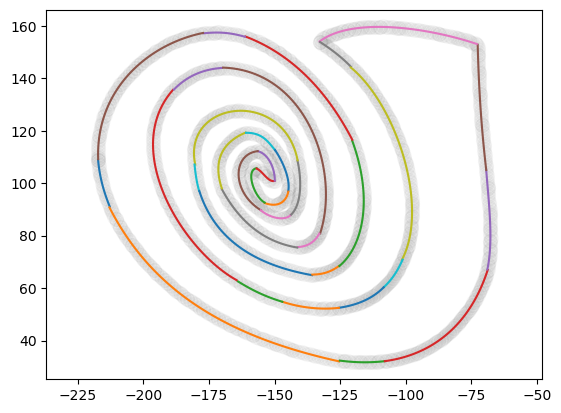

In [5]:
THRESHOLD = 0.1

def fit_bezier(seg, ts=None):

    # linear least squares
    if ts is None:
        ts = np.linspace(0, 1, len(seg))
    eT = np.array([ts**0, ts**1, ts**2, ts**3])
    c1 = np.linalg.solve(eT@eT.T, eT@seg)
    p1 = eT.T @ c1

    # iterative linear fit
    c2 = np.array(c1)
    dts = 0.0 * ts
    errs = 0.0 * ts
    for iter in range(3):
        for i in range(len(ts)):
            t, d = closest_point(c2, seg[i])
            assert 0.0 <= t <= 1.0
            dts[i] = t - ts[i]
            ts[i] += 1.5*dts[i]
            errs[i] = d
        ts = (ts-ts[0]) / (ts[-1]-ts[0])
        # ts = np.maximum(0.0, np.minimum(1.0, ts))
        eT = np.array([ts**0, ts**1, ts**2, ts**3])
        c2 = np.linalg.solve(eT@eT.T, eT@seg)
        maxdt = np.amax(abs(dts))
        maxerr = np.amax(errs)
        # print(maxdt)
        if maxdt < 1e-3:
            break
        if iter >= 2 and maxerr > 1.5 * THRESHOLD:
            break
        if maxerr < 0.5 * THRESHOLD:
            break

    return c2, ts, errs


def fit_spline(seg, ts=None):
    # print(seg.shape)
    c, ts, errs = fit_bezier(seg, ts)
    w = np.linspace(0, 1, len(errs))
    # w = (4.0*w*(1.0-w)) ** 0.5
    # maxi = np.argmax(errs*w)
    maxi = np.argmax(errs)

    # cut at minimum error
    # prevent cutting near end
    errss = gaussian_filter1d(errs, 0.025*len(errs), mode='reflect')
    mins = argrelextrema(errss, np.less)[0]
    # if errss[0] < errss[1]:
    #     mins = np.concatenate(([0], mins))
    # if errss[-1] < errss[-2]:
    #     mins = np.concatenate((mins, [len(errss)-1]))
    mins = [_ for _ in mins if 4 <= _ < len(seg)-4]
    maxi = len(seg) // 2
    if len(mins) >= 2:
        maxi = np.argmax(errs[mins[0]:mins[-1]])+mins[0]
    maxe = errs[maxi]

    if False:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
        ax1.plot(ts, errs)
        ax1.plot(ts, errss)
        ax1.plot(ts[mins], errs[mins], 'o')
        ax2.plot(seg[:, 0], seg[:, 1])
        ps = np.array([ts**0, ts**1, ts**2, ts**3]).T @ c
        ax2.plot(ps[:, 0], ps[:, 1])
        ax2.plot(ps[(mins[0], mins[-1]), 0], ps[(mins[0], mins[-1]), 1], 'o')
        ax2.axis('equal')
        plt.show()

    if maxi < 4 or maxi >= len(seg)-4:
        maxi = len(seg) // 2

    if np.mean(errs) < THRESHOLD or len(seg) < 8:
        return [(c, seg)]

    # ts1 = ts[:maxi+1] / ts[maxi]
    # ts2 = (ts[maxi:]-ts[maxi]) / (1.0-ts[maxi])
    ts1 = ts2 = None
    sp1 = fit_spline(seg[:maxi+1], ts1)
    sp2 = fit_spline(seg[maxi:], ts2)
    return sp1+sp2


# seg = contours[1][0:4*len(contours[1])//5, :]
# seg = contours[1][0:7*len(contours[1])//8, :]
# seg = contours[1]*1.0
seg = contours[2]*1.0
seg = np.flip(seg)
seg[:, 1] += 10.0 * np.sin(seg[:, 0]/40.0)
seg[:, 0] += 10.0 * np.cos(seg[:, 1]/40.0)
seg = np.concatenate((seg, seg[0:1]))

t0 = perf_counter()
spline = fit_spline(seg)
t1 = perf_counter()
print(t1-t0, "secs")
print(len(spline), 'pieces')

plt.figure()
plt.plot(seg[:, 0], seg[:, 1], 'k.', markersize=20, alpha=0.02)

for c, seg1 in spline:
    ts = np.linspace(0, 1)
    eT = np.array([ts**0, ts**1, ts**2, ts**3])
    p = eT.T @ c
    plt.plot(p[:, 0], p[:, 1])

plt.axis('equal')
plt.show()

Merge pieces

36 pieces
1.5789261040044948 secs
26 pieces
24 pieces
23 pieces
1.7924703470198438 secs


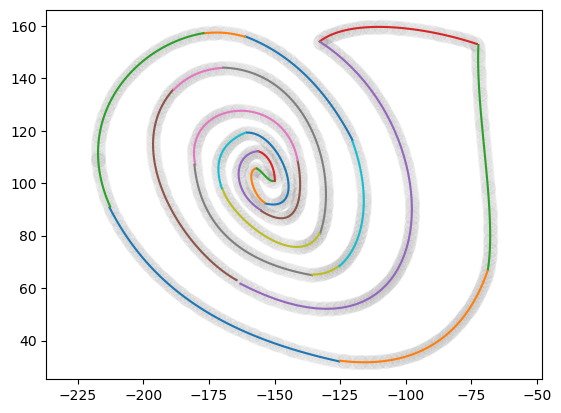

In [6]:
def merge_pieces(spline):
    n = len(spline)

    # find potential merge locations
    merges = [None] * n
    for i in range(len(spline)):
        j = (i+1) % len(spline)
        seg = np.concatenate((spline[i][1][:-1], spline[j][1]))
        c, ts, errs = fit_bezier(seg)
        if np.mean(errs) < THRESHOLD:
            merges[i] = {
                'i': i,
                'c': c,
                'err': np.mean(errs)
            }

    # get merge locations
    # optimize when there are multiple merges in a row
    mergepoints = []
    i0 = 0
    while i0 < n and merges[i0] is None:
        i0 += 1
    if i0 == n:
        return None
    i00 = (i0 - 1) % n
    while i0 != i00:
        i1 = (i0+1)%n
        while i1 != i00 and merges[i1] is not None:
            i1 = (i1+1) % n
        if (i1 - i0) % 2 == 1:
            # append
            for i in range(i0, i0+(i1-i0)%n, 2):
                mergepoints.append(i%n)
        else:
            # merge to give best results
            excludei = i0
            for i in range(i0, i0+(i1-i0)%n, 2):
                if merges[i%n]['err'] > merges[excludei]['err']:
                    excludei = i%n
            for i in range(i0, i0+(excludei-i0)%n, 2):
                mergepoints.append(i)
            for i in range(excludei, excludei+(i1-excludei)%n, 2):
                mergepoints.append(i)
        i0 = i1
        while i0 != i00 and merges[i0] is None:
            i0 = (i0+1)%n
    # print(sorted(mergepoints))

    # merge
    spline = spline[:]
    merged = [0] * len(spline)
    merged = [0] * len(spline)  # 0 not merged, 1 merged, 2 removed
    for i in mergepoints:
        j = (i+1)%n
        if merged[i] != 0 or merged[j] != 0:
            continue
        spline[i] = (
            merges[i]['c'],
            np.concatenate((spline[i][1][:-1], spline[j][1]))
        )
        merged[i] = 1
        merged[j] = 2
    return [spline[i] for i in range(len(spline)) if merged[i] != 2]


# seg = contours[1][0:4*len(contours[1])//5, :]
# seg = contours[1][0:7*len(contours[1])//8, :]
# seg = contours[1]*1.0
seg = contours[2]*1.0
# seg = contours[2]*0.5
# seg = contours[0]*1.0
seg = np.flip(seg)
seg[:, 1] += 10.0 * np.sin(seg[:, 0]/40.0)
seg[:, 0] += 10.0 * np.cos(seg[:, 1]/40.0)
seg = np.concatenate((seg, seg[0:1]))

t0 = perf_counter()
spline = fit_spline(seg)
t1 = perf_counter()
print(len(spline), 'pieces')
print(t1-t0, "secs")
while True:
    # to-do: reuse optimization computation
    spline1 = merge_pieces(spline)
    if spline1 is None:
        break
    spline = spline1
    print(len(spline), 'pieces')
t2 = perf_counter()
print(t2-t1, "secs")

plt.figure()
plt.plot(seg[:, 0], seg[:, 1], 'k.', markersize=20, alpha=0.02)

for c, seg1 in spline:
    ts = np.linspace(0, 1)
    eT = np.array([ts**0, ts**1, ts**2, ts**3])
    p = eT.T @ c
    plt.plot(p[:, 0], p[:, 1])

plt.axis('equal')
plt.show()